# Time series




In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt






## Intro

pandas has extensive support for handling dates and times.

We will loosely refer to data with date or time information as time
series data.

In this lecture, we will cover the most useful parts of pandas’ time
series functionality.

Among these topics are:

- Parsing strings as dates  
- Writing `datetime` objects as (inverse operation of previous point)  
- Extracting data from a DataFrame or Series with date information in
  the index  
- Shifting data through time (taking leads or lags)  
- Re-sampling data to a different frequency and rolling operations  


However, even more than with previous topics, we will skip a lot of the
functionality pandas offers, and we urge you to refer to the [official
documentation](https://pandas.pydata.org/pandas-docs/stable/timeseries.html)
for more information.

## Parsing Strings as Dates

When working with time series data, we almost always receive the data
with dates encoded as strings.

Hopefully, the date strings follow a structured format or pattern.

One common pattern is `YYYY-MM-DD`: 4 numbers for the year, 2 for the
month, and 2 for the day with each section separated by a `-`.

For example, we write Christmas day 2017 in this format as

In [35]:
christmas_str = "2017-12-25"

To convert a string into a time-aware object, we use the
`pd.to_datetime` function.

In [36]:
christmas = pd.to_datetime(christmas_str)
print("The type of christmas is", type(christmas))
christmas

The type of christmas is <class 'pandas._libs.tslibs.timestamps.Timestamp'>


Timestamp('2017-12-25 00:00:00')

The `pd.to_datetime` function is pretty smart at guessing the format
of the date…

In [37]:
for date in ["December 25, 2017", "Dec. 25, 2017",
             "Monday, Dec. 25, 2017", "25 Dec. 2017", "25th Dec. 2017"]:
    print("pandas interprets {} as {}".format(date, pd.to_datetime(date)))

pandas interprets December 25, 2017 as 2017-12-25 00:00:00
pandas interprets Dec. 25, 2017 as 2017-12-25 00:00:00
pandas interprets Monday, Dec. 25, 2017 as 2017-12-25 00:00:00
pandas interprets 25 Dec. 2017 as 2017-12-25 00:00:00
pandas interprets 25th Dec. 2017 as 2017-12-25 00:00:00


However, sometimes we will need to give pandas a hint.

For example, that same time (midnight on Christmas) would be reported on
an Amazon transaction report as

In [38]:
christmas_amzn = "2017-12-25T00:00:00+ 00 :00"

If we try to pass this to `pd.to_datetime`, it will fail.

```python
pd.to_datetime(christmas_amzn)
```


To parse a date with this format, we need to specify the `format`
argument for `pd.to_datetime`.

In [39]:
amzn_strftime = "%Y-%m-%dT%H:%M:%S+ 00 :00"
pd.to_datetime(christmas_amzn, format=amzn_strftime)

Timestamp('2017-12-25 00:00:00')

Can you guess what `amzn_strftime` represents?

Let’s take a closer look at `amzn_strftime` and `christmas_amzn`.

In [40]:
print(amzn_strftime)
print(christmas_amzn)

%Y-%m-%dT%H:%M:%S+ 00 :00
2017-12-25T00:00:00+ 00 :00


Notice that both of the strings have a similar form, but that instead of actual numerical values, `amzn_strftime` has *placeholders*.

Specifically, anywhere the `%` shows up is a signal to the `pd.to_datetime`
function that it is where relevant information is stored.

For example, the `%Y` is a stand-in for a four digit year, `%m` is
for 2 a digit month, and so on…

The official [Python
documentation](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) contains a complete list of possible `%`something patterns that are accepted
in the `format` argument.



### Multiple Dates

If we have dates in a Series (e.g. column of DataFrame) or a list, we
can pass the entire collection to `pd.to_datetime` and get a
collection of dates back.

We’ll just show an example of that here as the mechanics are the same as
a single date.

In [41]:
pd.to_datetime(["2017-12-25", "2017-12-31"])

DatetimeIndex(['2017-12-25', '2017-12-31'], dtype='datetime64[ns]', freq=None)

## Extracting Data

When the index of a DataFrame has date information and pandas
recognizes the values as `datetime` values, we can leverage some
convenient indexing features for extracting data.

The flexibility of these features is best understood through example,
so let’s load up some data and take a look.

___

Below we are using pandas data reader API that allows us to get Alpha Advantadge  finance data for free  [look here](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-naver)


You can apply for a free API key here https://www.alphavantage.co/support/#api-key

There is a wide range of different API for Python. We will later discuss a few more that we will use

In [43]:
import pandas_datareader.data as pdr
import datetime as dt

# yahoo, not currently working
#df = web.DataReader('GME', 'yahoo', start='2019-09-10', end='2019-10-09')

# alpha vantage, require api key
gme= pdr.DataReader("GME", "av-daily", start=dt.datetime(2013, 1, 2),
                      end=dt.datetime(2021, 11, 1),
                     api_key='N78MZQUK4ZCDUABU')


gme.tail()

,open,high,low,close,volume
2021-10-26,173.36,185.00,172.50,177.84,2176749
2021-10-27,180.00,183.09,172.33,173.51,1106998
2021-10-28,175.16,183.14,175.00,182.85,1696206
2021-10-29,182.81,185.75,178.00,183.51,2293970
2021-11-01,182.53,208.57,182.05,200.09,4910802


LEts start by getting prices back in 2015

In [44]:
#gme.loc["2015"]

What did go wrong?

In [45]:
gme.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2225 entries, 2013-01-02 to 2021-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2225 non-null   float64
 1   high    2225 non-null   float64
 2   low     2225 non-null   float64
 3   close   2225 non-null   float64
 4   volume  2225 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 104.3+ KB


Lets make sure that the index is interpeted as Date

In [46]:
gme.index=pd.to_datetime(gme.index)
gme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2225 entries, 2013-01-02 to 2021-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2225 non-null   float64
 1   high    2225 non-null   float64
 2   low     2225 non-null   float64
 3   close   2225 non-null   float64
 4   volume  2225 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 104.3 KB


Here, we have the Game Stop  from 2013 until today.

Notice that the type of index is `DateTimeIndex`.

This is the key that enables things like…

Extracting all data for the year 2015 by passing `"2015"` to `.loc`.

In [47]:
gme.loc["2015"]

,open,high,low,close,volume
2015-01-02,34.06,34.1600,33.2500,33.80,1612946
2015-01-05,33.52,34.8800,33.3300,34.72,4940754
2015-01-06,35.17,36.0300,33.5200,33.69,4885107
2015-01-07,34.29,34.6800,32.9800,33.30,2558324
2015-01-08,33.60,34.1700,33.3200,33.69,4547436
...,...,...,...,...,...
2015-12-24,28.62,28.8000,28.2799,28.37,868965
2015-12-28,28.37,28.9400,28.1400,28.47,2325435
2015-12-29,28.62,28.8000,28.3268,28.43,2041056
2015-12-30,28.37,28.9399,28.2400,28.48,1438398


We can also narrow down to specific months.

In [48]:
# By month's name
gme.loc["August 2017"]

,open,high,low,close,volume
2017-08-01,21.69,21.690,21.1400,21.36,3059060
2017-08-02,21.32,21.620,21.2718,21.38,1114494
2017-08-03,21.32,21.820,21.3200,21.66,1047946
2017-08-04,21.78,22.110,21.6874,21.93,1136118
2017-08-07,21.94,22.255,21.8250,22.17,1276275
2017-08-08,22.20,22.370,21.9000,21.94,1422533
2017-08-09,21.75,22.120,21.6200,22.08,1502404
2017-08-10,21.91,21.910,21.4600,21.47,1517745
2017-08-11,21.24,21.830,21.0700,21.76,1616078
2017-08-14,21.95,21.990,21.7150,21.85,1532902


In [49]:
# By month's number
gme.loc["08/2017"]

,open,high,low,close,volume
2017-08-01,21.69,21.690,21.1400,21.36,3059060
2017-08-02,21.32,21.620,21.2718,21.38,1114494
2017-08-03,21.32,21.820,21.3200,21.66,1047946
2017-08-04,21.78,22.110,21.6874,21.93,1136118
2017-08-07,21.94,22.255,21.8250,22.17,1276275
2017-08-08,22.20,22.370,21.9000,21.94,1422533
2017-08-09,21.75,22.120,21.6200,22.08,1502404
2017-08-10,21.91,21.910,21.4600,21.47,1517745
2017-08-11,21.24,21.830,21.0700,21.76,1616078
2017-08-14,21.95,21.990,21.7150,21.85,1532902


Or even a day…

In [50]:
# By date name
gme.loc["August 1, 2017"]

open           21.69
high           21.69
low            21.14
close          21.36
volume    3059060.00
Name: 2017-08-01 00:00:00, dtype: float64

In [51]:
# By date number
gme.loc["08-01-2017"]

open           21.69
high           21.69
low            21.14
close          21.36
volume    3059060.00
Name: 2017-08-01 00:00:00, dtype: float64

What can we pass as the `.loc` argument when we have a
`DateTimeIndex`?

Anything that can be converted to a `datetime` using
`pd.to_datetime`, *without* having to specify the format argument.

When that condition holds, pandas will return *all* rows whose date in
the index “belong” to that date or period.

We can also use the range shorthand notation to give a start and end
date for selection.

In [52]:
gme.loc["April 1, 2015":"April 10, 2015"]

,open,high,low,close,volume
2015-04-01,37.86,38.50,37.330,37.78,2464874
2015-04-02,38.06,38.81,37.880,38.20,1172602
2015-04-06,38.00,38.39,37.680,38.37,1483853
2015-04-07,38.37,38.50,37.915,37.98,1332103
2015-04-08,37.80,38.78,37.740,38.71,1649946
2015-04-09,38.76,40.00,38.350,39.99,1912082
2015-04-10,40.18,40.41,39.560,40.40,1268980


## Accessing Date Properties

Sometimes, we would like to directly access a part of the date/time.

If our date/time information is in the index, we can to `df.index.XX`
where `XX` is replaced by `year`, `month`, or whatever we would
like to access.

In [53]:
gme.index.year

Int64Index([2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', length=2225)

In [54]:
gme.index.day

Int64Index([ 2,  3,  4,  7,  8,  9, 10, 11, 14, 15,
            ...
            19, 20, 21, 22, 25, 26, 27, 28, 29,  1],
           dtype='int64', length=2225)

We can also do the same if the date/time information is stored in a
column, but we have to use a slightly different syntax.

```python
df["column_name"].dt.XX
```


In [55]:
gme_date_column = gme.reset_index()
gme_date_column.head()

,index,open,high,low,close,volume
0,2013-01-02,25.58,25.870,24.99,25.66,4898100
1,2013-01-03,25.58,25.685,23.92,24.36,10642800
2,2013-01-04,24.42,25.170,24.36,24.80,4040000
3,2013-01-07,24.66,24.920,23.87,24.75,3983900
4,2013-01-08,22.93,23.960,22.66,23.19,11131200


In [56]:
gme_date_column["index"].dt.year.head()

0    2013
1    2013
2    2013
3    2013
4    2013
Name: index, dtype: int64

In [57]:
gme_date_column["index"].dt.month.head()

0    1
1    1
2    1
3    1
4    1
Name: index, dtype: int64

## Leads and Lags: `df.shift`

When doing time series analysis, we often want to compare data at one
date against data at another date.

pandas can help us with this if we leverage the `shift` method.

Without any additional arguments, `shift()` will move all data
*forward* one period, filling the first row with missing data.

In [58]:
# so we can see the result of shift clearly
gme.head()

,open,high,low,close,volume
2013-01-02,25.58,25.870,24.99,25.66,4898100
2013-01-03,25.58,25.685,23.92,24.36,10642800
2013-01-04,24.42,25.170,24.36,24.80,4040000
2013-01-07,24.66,24.920,23.87,24.75,3983900
2013-01-08,22.93,23.960,22.66,23.19,11131200


In [59]:
gme.shift().head()

,open,high,low,close,volume
2013-01-02,NaN,NaN,NaN,NaN,NaN
2013-01-03,25.58,25.870,24.99,25.66,4898100.0
2013-01-04,25.58,25.685,23.92,24.36,10642800.0
2013-01-07,24.42,25.170,24.36,24.80,4040000.0
2013-01-08,24.66,24.920,23.87,24.75,3983900.0


We can use this to compute the percent change from one day to the next.
(Quiz: Why does that work? Remember how pandas uses the index to *align*
data.)

In [60]:
((gme.close - gme.close.shift()) / gme.close.shift()).head()

2013-01-02         NaN
2013-01-03   -0.050663
2013-01-04    0.018062
2013-01-07   -0.002016
2013-01-08   -0.063030
Name: close, dtype: float64

Setting the first argument to `n` tells pandas to shift the data down
`n` rows (apply an `n` period lag).

In [61]:
gme.shift(3).head()

,open,high,low,close,volume
2013-01-02,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN
2013-01-07,25.58,25.870,24.99,25.66,4898100.0
2013-01-08,25.58,25.685,23.92,24.36,10642800.0


A negative value will shift the data *up* or apply a lead.

In [62]:
gme.shift(-2).tail()

,open,high,low,close,volume
2021-10-26,175.16,183.14,175.00,182.85,1696206.0
2021-10-27,182.81,185.75,178.00,183.51,2293970.0
2021-10-28,182.53,208.57,182.05,200.09,4910802.0
2021-10-29,NaN,NaN,NaN,NaN,NaN
2021-11-01,NaN,NaN,NaN,NaN,NaN


In [63]:
gme.shift(-2).head()

,open,high,low,close,volume
2013-01-02,24.42,25.17,24.36,24.80,4040000.0
2013-01-03,24.66,24.92,23.87,24.75,3983900.0
2013-01-04,22.93,23.96,22.66,23.19,11131200.0
2013-01-07,23.12,23.32,22.52,22.61,4331900.0
2013-01-08,22.81,22.88,22.40,22.79,3900300.0


## Rolling Computations: `.rolling`

pandas has facilities that enable easy computation of *rolling
statistics*.

These are best understood by example, so we will dive right in.

In [64]:
# first take only the first 6 rows so we can easily see what is going on
gme_small = gme.head(6)
gme_small

,open,high,low,close,volume
2013-01-02,25.58,25.870,24.99,25.66,4898100
2013-01-03,25.58,25.685,23.92,24.36,10642800
2013-01-04,24.42,25.170,24.36,24.80,4040000
2013-01-07,24.66,24.920,23.87,24.75,3983900
2013-01-08,22.93,23.960,22.66,23.19,11131200
2013-01-09,23.12,23.320,22.52,22.61,4331900


Below, we compute the 2 day moving average (for all columns).

In [65]:
gme_small.rolling("2d").mean()

,open,high,low,close,volume
2013-01-02,25.580,25.8700,24.990,25.66,4898100.0
2013-01-03,25.580,25.7775,24.455,25.01,7770450.0
2013-01-04,25.000,25.4275,24.140,24.58,7341400.0
2013-01-07,24.660,24.9200,23.870,24.75,3983900.0
2013-01-08,23.795,24.4400,23.265,23.97,7557550.0
2013-01-09,23.025,23.6400,22.590,22.90,7731550.0


To do this operation, pandas starts at each row (date) then looks
*backwards* the specified number of periods (here 2 days) and then
applies some aggregation function (`mean`) on all the data in that
window.

If pandas cannot look back the full length of the window (e.g. when
working on the first row), it fills as much of the window as possible
and then does the operation. Notice that the value at 2013-02-25 is
the same in both DataFrames.

Below, we see a visual depiction of the rolling maximum on a 21 day
window for the whole dataset.

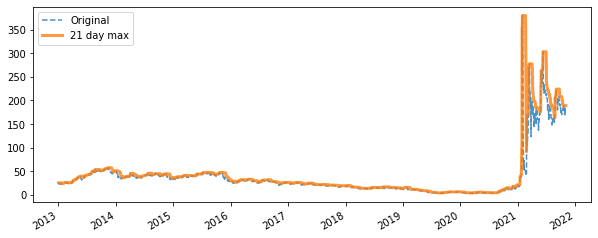

In [66]:
fig, ax = plt.subplots(figsize=(10, 4))
gme["open"].plot(ax=ax, linestyle="--", alpha=0.8)
gme.rolling("21d").max()["open"].plot(ax=ax, alpha=0.8, linewidth=3)
ax.legend(["Original", "21 day max"])

We can also ask pandas to `apply` custom functions, similar to what we
saw when studying GroupBy.

In [67]:
def is_volatile(x):
    "Returns a 1 if the variance is greater than 1, otherwise returns 0"
    if x.var() > 1.0:
        return 1.0
    else:
        return 0.0

In [68]:
gme_small.open.rolling("21d").apply(is_volatile)

2013-01-02    0.0
2013-01-03    0.0
2013-01-04    0.0
2013-01-07    0.0
2013-01-08    1.0
2013-01-09    1.0
Name: open, dtype: float64

## Changing Frequencies: `.resample` (Opt)

In addition to computing rolling statistics, we can also change the
frequency of the data.

For example, instead of a monthly moving average, suppose that we wanted
to compute the average *within* each calendar month.

We will use the `resample` method to do this.

Below are some examples.

In [69]:
# business quarter
gme.resample("BQ").mean()

,open,high,low,close,volume
2013-03-29,24.670000,25.070072,24.251587,24.744000,3.315910e+06
2013-06-28,35.254844,36.018991,34.700516,35.398438,4.000192e+06
2013-09-30,47.824062,48.547236,47.145555,47.809062,2.185230e+06
2013-12-31,51.333750,51.968745,50.496134,51.277344,2.739705e+06
2014-03-31,38.386230,39.046482,37.721043,38.420984,4.613946e+06
2014-06-30,39.208889,39.785459,38.583568,39.152540,2.880822e+06
2014-09-30,42.605937,43.126973,41.989127,42.523750,2.490632e+06
2014-12-31,38.776094,39.396766,38.087609,38.687188,3.475835e+06
2015-03-31,37.692623,38.290061,36.998803,37.606721,2.332886e+06
2015-06-30,41.116825,41.542130,40.632362,41.114603,1.663396e+06


Note that unlike with `rolling`, a single number is returned for
each column for each quarter.

The `resample` method will alter the frequency of the data and the
number of rows in the result will be different from the number of rows
in the input.

On the other hand, with `rolling`, the size and frequency of the result
are the same as the input.

We can sample at other frequencies and aggregate with multiple aggregations
function at once.

In [70]:
# multiple functions at 2 start-of-quarter frequency
gme.resample("2BQS").agg(["min", "max"])

open              high               low             close  \
               min     max       min       max     min       max     min   
2013-01-01   22.68   41.41   22.8800   42.8400   22.30   41.1200   22.61   
2013-07-01   42.00   57.68   42.3400   57.7400   41.66   56.9200   42.17   
2014-01-01   33.67   49.71   34.3800   50.0000   33.10   49.0700   33.83   
2014-07-01   32.11   46.06   32.7300   46.5900   31.81   45.8600   31.92   
2015-01-01   32.55   44.58   33.7100   45.5000   31.69   44.1624   32.27   
2015-07-01   28.37   47.62   28.8000   47.8250   27.90   46.9000   28.04   
2016-01-01   25.06   33.20   25.4500   33.7200   24.33   33.1000   25.06   
2016-07-01   20.59   32.13   20.9200   32.6700   20.10   31.8300   20.73   
2017-01-02   20.33   26.33   20.6600   26.6799   20.24   26.0200   20.46   
2017-07-03   16.01   22.20   16.3800   22.3700   15.85   21.9000   16.00   
2018-01-01   12.51   19.92   12.7500   20.3100   12.20   19.7700   12.46   
2018-07-02   11.72   16.98   12.0200   17.2700   11.56   16.6200   11.67   
2019-01-01    4.98   16.02    5.1300   16.9000    4.71   15.8800    5.02   
2019-07-01    3.25    6.65    3.3600    6.9200    3.15    6.3900    3.21   
2020-01-01    2.85    6.21    2.9400    6.4700    2.57    6.0700    2.80   
2020-07-01    3.90   21.31    4.0490   22.3499    3.77   20.3500    3.85   
2021-01-01   17.34  379.71   18.0765  483.0000   17.08  291.5100   17.25   
2021-07-01  148.00  224.00  156.5000  231.4390  145.22  211.4600  146.80   

                     volume             
               max      min        max  
2013-01-01   42.03  1203200   13867200  
2013-07-01   57.59   626000   14606000  
2014-01-01   49.65  1317800   23506700  
2014-07-01   46.10  1102800   18759780  
2015-01-01   44.55   747201    8682832  
2015-07-01   47.44   746129   16927011  
2016-01-01   33.38  1264704   22220471  
2016-07-01   32.16  1031652   14493353  
2017-01-02   26.52  1135065   15943366  
2017-07-03   22.17   972854   20500700  
2018-01-01   19.96  1840539   25823988  
2018-07-02   17.04  1289301   17471600  
2019-01-01   15.98  1282019   39354238  
2019-07-01    6.68  1368983   33980425  
2020-01-01    6.31  1467612   13491454  
2020-07-01   20.99  1330148   77152780  
2021-01-01  347.51  1789186  194084194  
2021-07-01  218.24   818207   14652209

As with `groupby` and `rolling`, you can also provide custom
functions to `.resample(...).agg` and `.resample(...).apply`



To make the optimal decision we need to, for each month,
compute the maximum value of the close price on any day minus the open
price on the first day of the month.

